## Import necessary library

In [43]:
from keras.models import load_model
import mtcnn
from PIL import Image
from numpy import asarray
from mtcnn.mtcnn import MTCNN
from matplotlib import pyplot
from os import listdir
from os.path import isdir
from numpy import savez_compressed
from numpy import load
from numpy import expand_dims
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC
from random import choice


## Load the model

In [15]:
# load the model
model = load_model('facenet_keras.h5')
# summarize input and output shape
print(model.inputs)
print(model.outputs)

[<tf.Tensor 'input_1_2:0' shape=(?, 160, 160, 3) dtype=float32>]
[<tf.Tensor 'Bottleneck_BatchNorm_2/cond/Merge:0' shape=(?, 128) dtype=float32>]


## The function extract_face() will load a photograph from the loaded filename and return the extracted face. It assumes that the photo contains one face and will return the first face detected.

In [16]:
# extract a single face from a given photograph
def extract_face(filename, required_size=(160, 160)):
	# load image from file
	image = Image.open(filename)
	# convert to RGB, if needed
	image = image.convert('RGB')
	# convert to array
	pixels = asarray(image)
	# create the detector, using default weights
	detector = MTCNN()
	# detect faces in the image
	results = detector.detect_faces(pixels)
	# extract the bounding box from the first face
	x1, y1, width, height = results[0]['box']
	# bug fix
	x1, y1 = abs(x1), abs(y1)
	x2, y2 = x1 + width, y1 + height
	# extract the face
	face = pixels[y1:y2, x1:x2]
	# resize pixels to the model size
	image = Image.fromarray(face)
	image = image.resize(required_size)
	face_array = asarray(image)
	return face_array

## We take all pictures from that folder and extract faces from them

1 (160, 160, 3)
2 (160, 160, 3)
3 (160, 160, 3)
4 (160, 160, 3)
5 (160, 160, 3)
6 (160, 160, 3)
7 (160, 160, 3)
8 (160, 160, 3)
9 (160, 160, 3)
10 (160, 160, 3)
11 (160, 160, 3)
12 (160, 160, 3)
13 (160, 160, 3)
14 (160, 160, 3)


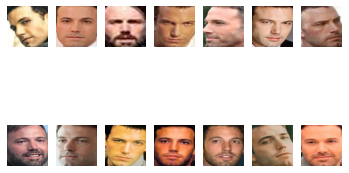

In [17]:
# specify folder to plot
folder = '5-celebrity-faces-dataset/train/ben_afflek/'
i = 1
# enumerate files
for filename in listdir(folder):
	# path
	path = folder + filename
	# get face
	face = extract_face(path)
	print(i, face.shape)
	# plot
	pyplot.subplot(2, 7, i)
	pyplot.axis('off')
	pyplot.imshow(face)
	i += 1
pyplot.show()

## The load_faces() function below will load all of the faces into a list for a given directory, e.g. ‘5-celebrity-faces-dataset/train/ben_afflek/‘.

In [18]:
# load images and extract faces for all images in a directory
def load_faces(directory):
	faces = list()
	# enumerate files
	for filename in listdir(directory):
		# path
		path = directory + filename
		# get face
		face = extract_face(path)
		# store
		faces.append(face)
	return faces

### We can call the load_faces() function for each subdirectory in the ‘train‘ or ‘val‘ folders. Each face has one label, the name of the celebrity, which we can take from the directory name.

### The load_dataset() function below takes a directory name such as ‘5-celebrity-faces-dataset/train/‘ and detects faces for each subdirectory (celebrity), assigning labels to each detected face.

### It returns the X and y elements of the dataset as NumPy arrays.

In [19]:
# load a dataset that contains one subdir for each class that in turn contains images
def load_dataset(directory):
	X, y = list(), list()
	# enumerate folders, on per class
	for subdir in listdir(directory):
		# path
		path = directory + subdir + '/'
		# skip any files that might be in the dir
		if not isdir(path):
			continue
		# load all faces in the subdirectory
		faces = load_faces(path)
		# create labels
		labels = [subdir for _ in range(len(faces))]
		# summarize progress
		print('>loaded %d examples for class: %s' % (len(faces), subdir))
		# store
		X.extend(faces)
		y.extend(labels)
	return asarray(X), asarray(y)

## We can then call this function for the ‘train’ and ‘val’ folders to load all of the data, then save the results in a single compressed NumPy array file via the savez_compressed() function.

In [22]:
# load train dataset
trainX, trainy = load_dataset('5-celebrity-faces-dataset/train/')
print(trainX.shape, trainy.shape)
# load test dataset
testX, testy = load_dataset('5-celebrity-faces-dataset/val/')
print(testX.shape, testy.shape)
# save arrays to one file in compressed format
savez_compressed('5-celebrity-faces-dataset.npz', trainX, trainy, testX, testy)

>loaded 14 examples for class: ben_afflek
>loaded 17 examples for class: elton_john
>loaded 21 examples for class: jerry_seinfeld
>loaded 19 examples for class: madonna
>loaded 22 examples for class: mindy_kaling
(93, 160, 160, 3) (93,)
>loaded 5 examples for class: ben_afflek
>loaded 5 examples for class: elton_john
>loaded 5 examples for class: jerry_seinfeld
>loaded 5 examples for class: madonna
>loaded 5 examples for class: mindy_kaling
(25, 160, 160, 3) (25,)


### A face embedding is a vector that represents the features extracted from the face. This can then be compared with the vectors generated for other faces. For example, another vector that is close (by some measure) may be the same person, whereas another vector that is far (by some measure) may be a different person.

### The classifier model that we want to develop will take a face embedding as input and predict the identity of the face. The FaceNet model will generate this embedding for a given image of a face.

### The FaceNet model can be used as part of the classifier itself, or we can use the FaceNet model to pre-process a face to create a face embedding that can be stored and used as input to our classifier model. This latter approach is preferred as the FaceNet model is both large and slow to create a face embedding.

### We can, therefore, pre-compute the face embeddings for all faces in the train and test (formally ‘val‘) sets in our 5 Celebrity Faces Dataset.

### First, we can load our detected faces dataset using the load() NumPy function.

In [25]:
# load the face dataset
data = load('5-celebrity-faces-dataset.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Loaded: ', trainX.shape, trainy.shape, testX.shape, testy.shape)

Loaded:  (93, 160, 160, 3) (93,) (25, 160, 160, 3) (25,)


### The get_embedding() function defined below implements these behaviors and will return a face embedding given a single image of a face and the loaded FaceNet model.

In [26]:
# get the face embedding for one face
def get_embedding(model, face_pixels):
	# scale pixel values
	face_pixels = face_pixels.astype('float32')
	# standardize pixel values across channels (global)
	mean, std = face_pixels.mean(), face_pixels.std()
	face_pixels = (face_pixels - mean) / std
	# transform face into one sample
	samples = expand_dims(face_pixels, axis=0)
	# make prediction to get embedding
	yhat = model.predict(samples)
	return yhat[0]

In [27]:
# convert each face in the train set to an embedding
newTrainX = list()
for face_pixels in trainX:
	embedding = get_embedding(model, face_pixels)
	newTrainX.append(embedding)
newTrainX = asarray(newTrainX)
print(newTrainX.shape)
# convert each face in the test set to an embedding
newTestX = list()
for face_pixels in testX:
	embedding = get_embedding(model, face_pixels)
	newTestX.append(embedding)
newTestX = asarray(newTestX)
print(newTestX.shape)
# save arrays to one file in compressed format
savez_compressed('5-celebrity-faces-embeddings.npz', newTrainX, trainy, newTestX, testy)


(93, 128)
(25, 128)


### In this section, we will develop a model to classify face embeddings as one of the known celebrities in the 5 Celebrity Faces Dataset.

### First, we must load the face embeddings dataset.

In [28]:
# load dataset
data = load('5-celebrity-faces-embeddings.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Dataset: train=%d, test=%d' % (trainX.shape[0], testX.shape[0]))

Dataset: train=93, test=25


### Next, the data requires some minor preparation prior to modeling.

### First, it is a good practice to normalize the face embedding vectors. It is a good practice because the vectors are often compared to each other using a distance metric.

### In this context, vector normalization means scaling the values until the length or magnitude of the vectors is 1 or unit length. This can be achieved using the Normalizer class in scikit-learn. It might even be more convenient to perform this step when the face embeddings are created in the previous step.

In [29]:
# normalize input vectors
in_encoder = Normalizer(norm='l2')
trainX = in_encoder.transform(trainX)
testX = in_encoder.transform(testX)

## Next, the string target variables for each celebrity name need to be converted to integers.

## This can be achieved via the LabelEncoder class in scikit-learn.

In [30]:
# label encode targets
out_encoder = LabelEncoder()
out_encoder.fit(trainy)
trainy = out_encoder.transform(trainy)
testy = out_encoder.transform(testy)

### Next, we can fit a model.

### It is common to use a Linear Support Vector Machine (SVM) when working with normalized face embedding inputs. This is because the method is very effective at separating the face embedding vectors. We can fit a linear SVM to the training data using the SVC class in scikit-learn and setting the ‘kernel‘ attribute to ‘linear‘. We may also want probabilities later when making predictions, which can be configured by setting ‘probability‘ to ‘True‘

In [38]:
# fit model
model = SVC(kernel='linear',probability=True)
model.fit(trainX, trainy)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

## Next, we can evaluate the model.

## This can be achieved by using the fit model to make a prediction for each example in the train and test datasets and then calculating the classification accuracy.

In [32]:
# predict
yhat_train = model.predict(trainX)
yhat_test = model.predict(testX)
# score
score_train = accuracy_score(trainy, yhat_train)
score_test = accuracy_score(testy, yhat_test)
# summarize
print('Accuracy: train=%.3f, test=%.3f' % (score_train*100, score_test*100))

Accuracy: train=100.000, test=100.000


## We can make it more interesting by plotting the original face and the prediction.

## First, we need to load the face dataset, specifically the faces in the test dataset. We could also load the original photos to make it even more interesting.

In [33]:
# load faces
data = load('5-celebrity-faces-dataset.npz')
testX_faces = data['arr_2']

### The rest of the example is the same up until we fit the model.

### First, we need to select a random example from the test set, then get the embedding, face pixels, expected class prediction, and the corresponding name for the class.

In [34]:
# test model on a random example from the test dataset
selection = choice([i for i in range(testX.shape[0])])
random_face_pixels = testX_faces[selection]
random_face_emb = testX[selection]
random_face_class = testy[selection]
random_face_name = out_encoder.inverse_transform([random_face_class])

### Next, we can use the face embedding as an input to make a single prediction with the fit model.

### We can predict both the class integer and the probability of the prediction.

In [39]:
# prediction for the face
samples = expand_dims(random_face_emb, axis=0)
yhat_class = model.predict(samples)
yhat_prob = model.predict_proba(samples)

### We can then get the name for the predicted class integer, and the probability for this prediction.

In [40]:
# get name
class_index = yhat_class[0]
class_probability = yhat_prob[0,class_index] * 100
predict_names = out_encoder.inverse_transform(yhat_class)

In [41]:
print('Predicted: %s (%.3f)' % (predict_names[0], class_probability))
print('Expected: %s' % random_face_name[0])

Predicted: jerry_seinfeld (75.780)
Expected: jerry_seinfeld


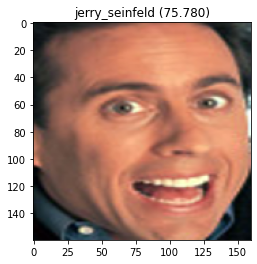

In [42]:
# plot for fun
pyplot.imshow(random_face_pixels)
title = '%s (%.3f)' % (predict_names[0], class_probability)
pyplot.title(title)
pyplot.show()